In [ ]:
#@title # [minDALL-E github](https://github.com/kakaobrain/minDALL-E)
#@markdown also checkout https://colab.research.google.com/drive/1Gg7-c7LrUTNfQ-Fk-BVNCe9kvedZZsAh?usp=sharing

#@markdown notebook by Annas


In [ ]:
#@title check gpu type
#@markdown if you get k80 it would be really slow try again by clicking runtime -> factory reset runtime until you get T4

#@markdown if you can't get T4 it's okay

#@markdown but keep in mind T4 is 9x faster than k80
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-edec8235-5d5b-5625-83f1-3a0324d62687)


In [ ]:
#@title setup run this once

from IPython.display import clear_output
import torch
import torch.nn as nn
torch.cuda.empty_cache()
!pip install rudalle==0.4.0 > /dev/null
!git clone -q https://github.com/kakaobrain/minDALL-E.git

%cd minDALL-E/

!pip install -q tokenizers>=0.10.2
!pip install -q pyflakes>=2.2.0
!pip install -q tqdm>=4.46.0
!pip install -q pytorch-lightning>=1.5
!pip install -q einops
!pip install -q omegaconf
!pip install -q git+https://github.com/openai/CLIP.git
!pip install "torchmetrics<0.7"

clear_output()

In [ ]:
#@title run this once also if you want to reload everything you can run this too

import os
from rudalle import get_realesrgan
from rudalle.pipelines import show, super_resolution
import torch
from dalle.utils.utils import set_seed
from dalle.models import Dalle
import clip
import math

torch.cuda.empty_cache()

device = "cuda" if torch.cuda.is_available() else "cpu"

with torch.no_grad():
  model = Dalle.from_pretrained("minDALL-E/1.3B")
  model.to(device=device)
  torch.cuda.empty_cache()
  realesrgan = get_realesrgan("x2", device=device)
  torch.cuda.empty_cache()
  model_clip, preprocess_clip = clip.load("ViT-B/32", device=device)
  model_clip.to(device=device)
  torch.cuda.empty_cache()


clear_output()

avocado smilling. avocado smilling. avocado smilling. avocado smilling. avocado smilling. avocado smilling. avocado smilling. avocado smilling. avocado smilling.


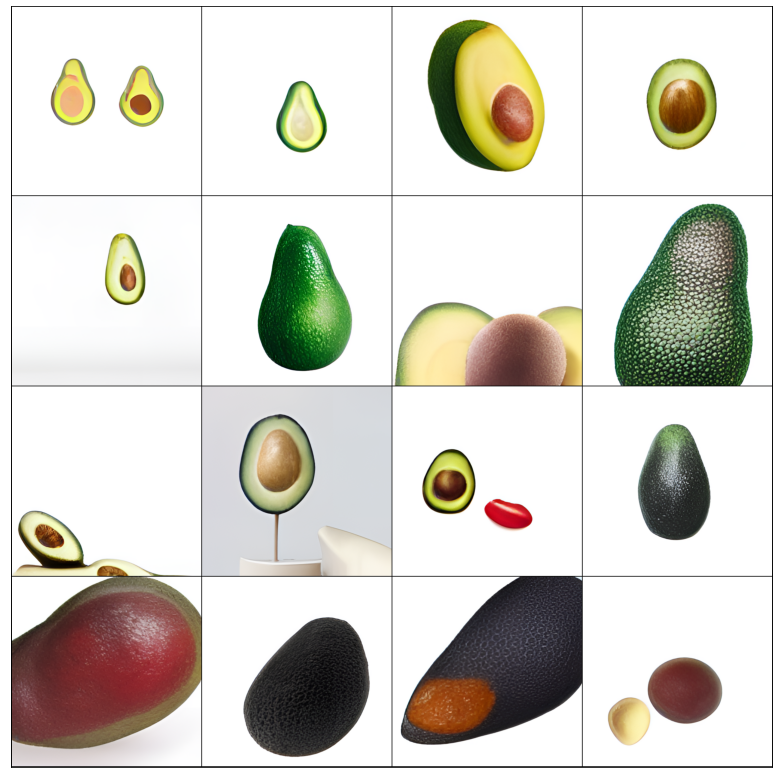

In [ ]:
torch.cuda.empty_cache()

import clip
import torch
import numpy as np
from dalle.models import Dalle
from dalle.utils.utils import clip_score
from PIL import Image

#@markdown prompt for the AI
prompt = "avocado smilling. avocado smilling. avocado smilling. avocado smilling. avocado smilling. avocado smilling. avocado smilling. avocado smilling. avocado smilling." #@param {type:"string"}

#@markdown number of images to be generated
num_candidates =  16#@param {type:"integer"}

#@markdown images per batch
batch_size =  8#@param {type:"integer"}

#@markdown number of image to be showed after re-ranking with clip
num_show = 16 #@param {type:"integer"}

#@markdown set this to False to disable realesrgan
use_realesrgan = True #@param {type:"boolean"}

#@markdown if nonzero, limits the sampled tokens to the top k values
top_k = 128 #@param {type:"integer"}

#@markdown if nonzero, limits the sampled tokens to the cumulative probability
top_p = None #@param {type:"raw"}

#@markdown controls the "craziness" of the generation
temperature = 0.7 #@param {type:"number"}


images = []
print(prompt)

for i in range(int(num_candidates / batch_size)):
    images.append(model.sampling(prompt=prompt,
                            top_k=top_k,
                            top_p=top_p,
                            softmax_temperature=temperature,
                            num_candidates=batch_size,
                            device=device).cpu().numpy())
    
    torch.cuda.empty_cache()

images = np.concatenate(images)
images = np.transpose(images, (0, 2, 3, 1))

if num_candidates > 1:
    rank = clip_score(prompt=prompt,
                      images=images,
                      model_clip=model_clip,
                      preprocess_clip=preprocess_clip,
                      device=device)

    torch.cuda.empty_cache()

    images = images[rank]

num_show = num_show if num_candidates >= num_show else num_candidates

images = [Image.fromarray((images[i] * 255).astype("uint8")) for i in range(num_show)]

if use_realesrgan:
    images = super_resolution(images, realesrgan)

clear_output()
print(prompt)

show(images, int(math.ceil(num_show / math.sqrt(num_show)))) # perfect square when using square numbers by litevex#6982